**WEEK 1**

---



**Task 1 — Load and Inspect the Dataset**

Load the Online Retail

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Load dataset
df = pd.read_csv("/content/online_retail_II.csv", encoding='latin-1')


Inspect the dataset

Display First few rows

In [ ]:
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/2009 07:45,1.25,13085.0,United Kingdom


number of rows and columns

In [ ]:
df.shape


(525461, 8)

column names

In [ ]:
df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

basic data types

In [ ]:
df.dtypes


,0
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
Price,float64
Customer ID,float64
Country,object


Explanation:

Within the Online Retail dataset, an invoice line item can be described as a single row. In a concrete manner, this is equal to a single product being purchased in a specific quantity at a particular price in a transaction at a specific point in time. As one invoice (or shopping basket) may contain more than one product, which are each contained in a distinct row, multiple rows may have the same invoice number. If one customer makes more than one purchase over time or if more than one item is purchased on a single invoice by the same customer, then multiple rows would also have the same Customer ID. So, rows in this dataset are part of some larger transactional structures, not distinct observations.

**Task 2 — Define the Unit of Analysis**

1.Invoice line (row level)

Advantages:

Comprehensive product level details, including each product's quantity and unit cost.helpful for examining the sales and pricing trends of specific products

Disadvantages

Total transaction value, complete shopping basket context.Consumer purchasing patterns across several items or visits

2.Invoice / basket level

Advantages
Total amount spent for every transaction Size of basket (items per invoice)
Understanding how customers behave when they shop

Disadvantages

Particular characteristics at the product level Long-term customer behavior across multiple invoices

3.Customer level:

Advantages
Total amount spent on each customer Regularity of purchases The average number of invoices Overall trends in consumer purchases

Disadvantages

timing of individual transactions and changes in behavior over time. Details at the product level

Decision

Chosen unit of analysis: Customer level

Aggregation at the customer level is chosen because it allows for insightful behavioral analysis, such as knowing how often customers make purchases and how much they spend overall. This approach avoids treating individual invoice lines as independent observations and provides a strong foundation for future modelling tasks such as customer segmentation or value-based analysis in subsequent weeks.


**Task 3 — Data quality and validity audit**

1.Missing or invalid Customer ID

Description
A number of transactions do not provide a valid Customer ID value.

Why it matters:
Connecting transactions to individual customers requires a Customer ID. Missing customer IDs prevent accurate aggregation at the customer level and make repeat purchase behaviour or customer value impossible to analyse.

Planned handling:
Customer-level analysis will not be performed on rows that have missing Customer IDs. This means that behavioural features are only calculated on identifiable customers, which increases the validity of downstream modelling.

3.Cancelled invoices

Description:

 Some invoice numbers begin with the letter “C”, representing cancelled transactions.

Why it matters:

 Cancelled invoices do not represent completed sales. Including them would artificially inflate transaction counts and misrepresent actual purchasing behaviour.

Planned handling:

Cancelled invoices will be filtered out from the main analysis dataset, as they do not correspond to successful transactions.

**Task 4 — Minimal, Justified Cleaning**

1.Handling missing Customer IDs

Description:

Some transactions do not have a Customer ID

why its matters:

Multiple transactions linking to the same user require Customer ID. It is essential for customer-level analyses and behavioural aggregates; otherwise, this method is not available.
```

```



Before Cleaning

In [ ]:
df['Customer ID'].isna().sum()


np.int64(107927)

Cleaning step

In [ ]:
df_clean = df.dropna(subset=['Customer ID'])


After Cleaning

In [ ]:
df_clean['Customer ID'].isna().sum()


np.int64(0)

Impact of the decision

Removing rows with missing Customer IDs cuts down the dataset size but ensures that all other transactions can be reliably associated with individual customers, which thus enhances the validity of customer-level analysis.

2.Separating returns from purchases

Description

 Some of the rows contain negative values in the Quantity column, which represent product returns rather than purchases.

 Why this matters.

  Returns shouldn’t be seen as sales because they distort revenue, basket size, and purchase frequency estimates

Before cleaning:

In [ ]:
(df_clean['Quantity'] < 0).sum()



np.int64(9839)

Cleaning steps

In [ ]:
purchases = df_clean[df_clean['Quantity'] > 0].copy()
returns = df_clean[df_clean['Quantity'] < 0].copy()

After Cleaning

In [ ]:
purchases.shape, returns.shape


((407695, 8), (9839, 8))

impact

By separating returns, negative quantities are not used to affect sales analyses, whilst the return data can still be preserved, at least for possible future

**Task 5 — Exploratory Data Analysis (EDA)**

1.EDA Output 1 —
Purchases over time (Temporal pattern)


/tmp/ipython-input-3366098430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['InvoiceDate'] = pd.to_datetime(purchases['InvoiceDate'], dayfirst=True)


<Axes: title={'center': 'Number of Purchases Over Time'}, xlabel='InvoiceDate'>

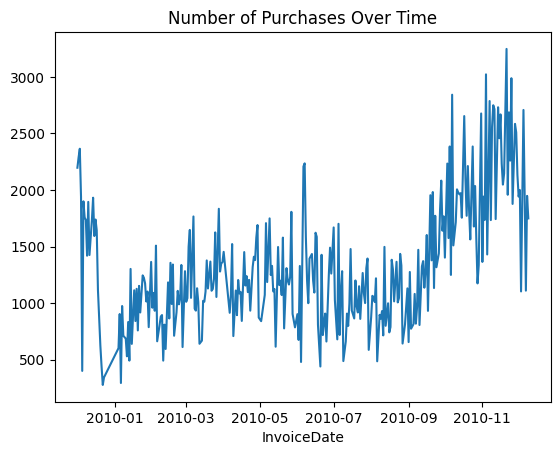

In [ ]:
purchases['InvoiceDate'] = pd.to_datetime(purchases['InvoiceDate'], dayfirst=True)

# Number of purchases over time
purchases_per_day = purchases.groupby(
    purchases['InvoiceDate'].dt.date
).size()

purchases_per_day.plot(title="Number of Purchases Over Time")


Question:

What is the evolution of the quantity of purchases?

Key pattern:
The quantity of purchases varies over time. There may be seasonal or time-based purchasing behavior when certain periods exhibit greater transaction activity than others.

Limitation:
Only the quantity of purchases is taken into account in this analysis; the amount spent and whether or not items were returned are not.



2.EDA Output 2 — Revenue across Time (Temporal Pattern).

<Axes: title={'center': 'Revenue Over Time'}, xlabel='InvoiceDate'>

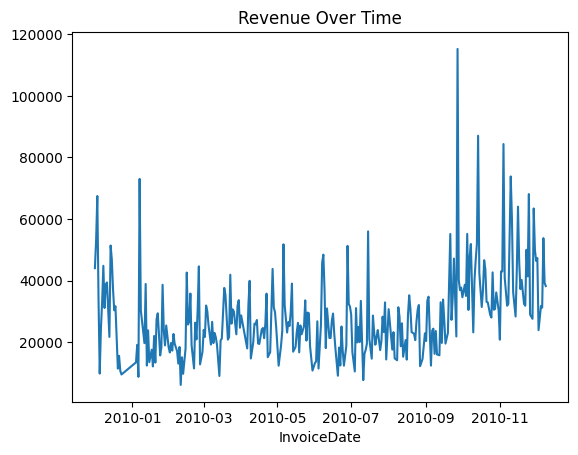

In [ ]:
purchases['InvoiceDate'] = pd.to_datetime(purchases['InvoiceDate'], dayfirst=True)
# Create revenue column
purchases['Revenue'] = purchases['Quantity'] * purchases['Price']

# Revenue over time
revenue_over_time = purchases.groupby(
    purchases['InvoiceDate'].dt.date
)['Revenue'].sum()

revenue_over_time.plot(title="Revenue Over Time")



Question:
What is the evolution of revenue over time?

Method:
To determine revenue, we multiplied quantity by unit price and then aggregated by date.


 Key pattern:

Similar trends to transaction volume are seen in revenue, which typically rises during times of increased purchase activity.

Limitation:

A few large orders could have a significant impact on overall revenue figures.

EDA Output 3 A product or country pattern

<Axes: title={'center': 'Basket Size Distribution'}, ylabel='Frequency'>

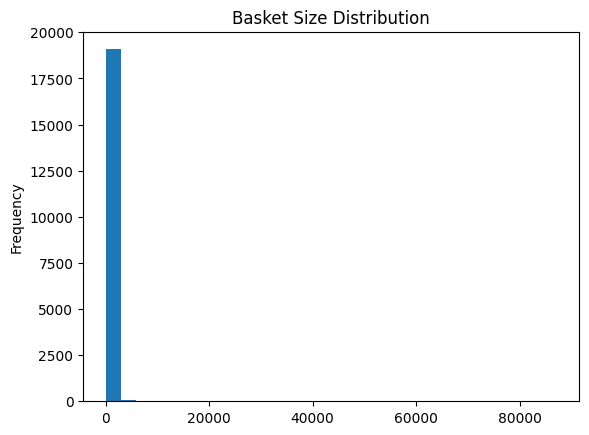

In [ ]:
# Basket size per invoice
basket_size = purchases.groupby('Invoice')['Quantity'].sum()

basket_size.plot(kind='hist', bins=30, title="Basket Size Distribution")




Question:

On an invoice, how many items are usually purchased?


Key pattern:

A small number of items are purchased on the majority of invoices.

Only a small number of invoices, though, have a large basket size.

Limitation:

The size of the basket only displays the number of items;

The monetary value is not reflected in it.



EDA Output 4
 — Invoice value distribution (The Transactional pattern).

<Axes: title={'center': 'Invoice Value Distribution'}, ylabel='Frequency'>

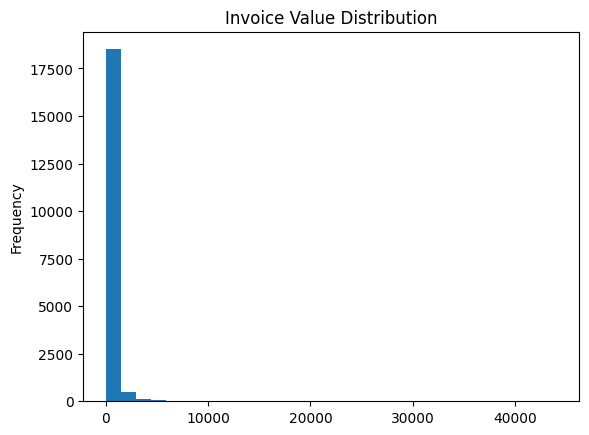

In [ ]:
# Invoice value
invoice_value = purchases.groupby('Invoice')['Revenue'].sum()

invoice_value.plot(kind='hist', bins=30, title="Invoice Value Distribution")



Question:

What is the invoice value distribution?

Key pattern:
There are a few high-value transactions among the majority of invoices with low total values.


Limitation:

Business clients may be represented by high-value invoices.

TASK-6

Key Insights from Week 1 Analysis:

No single row can be regarded as an individual observation because the entire dataset is transactional in nature.

The majority of the total revenue comes from a small number of transactions, even though the shopping basket size is typically small.

The data clearly shows temporal variability, which could be a reflection of seasonal or time-based buying patterns.

Assumptions and Risks:


The removal of transactions without a customer ID may have left out some real purchases, which could introduce bias.

Short-term or invoice-level purchasing behavior may be concealed when the data is converted to customer-level aggregation.



Chosen Unit of Analysis:

The following studies will use customer-level aggregation as their unit of analysis.


This will assist us in comprehending our customers' overall purchasing habits.

Planned Modeling Task:

We intend to perform customer segmentation using this dataset in the upcoming analysis phase.

This will examine consumer behavior using metrics like average invoice value, total spending, and frequency of purchases.